# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [66]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [67]:

np.random.seed(2315668) 
#
random.seed(2315668)


tf.random.set_seed(2315668)

K.clear_session() # Set seed for Keras

In [68]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [69]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [70]:
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [71]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, 
              #verbose=0,
             verbose=1)
    return model

## 2 Clients

In [72]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, 
                                                                  #random_state=42,
                                                  # Put your SID instead of number '42'                
                                                                  random_state= 2167288
                                                                 )

In [73]:
print(x_train_c1.shape)
print(x_train_c2.shape)
print(y_train_c1.shape)
print(y_train_c2.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000,)
(30000,)


In [74]:
# Create and train client models

client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)

Epoch 1/5
938/938 [==============================] - 3s 2ms/step - loss: 0.3421 - accuracy: 0.9035
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1590 - accuracy: 0.9539
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1101 - accuracy: 0.9661
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0807 - accuracy: 0.9753
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0616 - accuracy: 0.9818
Epoch 1/5
938/938 [==============================] - 2s 2ms/step - loss: 0.3383 - accuracy: 0.9047
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1548 - accuracy: 0.9555
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.1064 - accuracy: 0.9693
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0802 - accuracy: 0.9763
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.0602 - accuracy: 0.9820


In [75]:
# Federated averaging

def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [76]:
# Aggregate models

aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [77]:
# Create global model and set weights

global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [78]:
# Evaluate global model

test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 0.3638 - accuracy: 0.8824 - 549ms/epoch - 2ms/step
Test accuracy: 0.8823999762535095


In [79]:
test_accuracy = []

In [80]:
test_accuracy.append(0.8851000070571899)

In [81]:
test_accuracy

[0.8851000070571899]

#### Write your code to calculate precision, recall, and F-score


In [82]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [83]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 1ms/step
(10000, 10)


In [84]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.95      0.94      1032
           3       0.67      0.93      0.78      1010
           4       0.95      0.93      0.94       982
           5       0.78      0.96      0.86       892
           6       0.96      0.94      0.95       958
           7       0.99      0.55      0.71      1028
           8       0.98      0.70      0.81       974
           9       0.85      0.90      0.87      1009

    accuracy                           0.88     10000
   macro avg       0.90      0.88      0.88     10000
weighted avg       0.90      0.88      0.88     10000



In [85]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

Accuracy test set:  0.8824
Precision test set:  0.9001010249834084
Recall test set:  0.8824
F-score test set:  0.8792936550603081


In [86]:
test_precision = []
test_recall    = []
test_f1_score  = []

In [87]:
test_precision.append(0.907323157047967)
test_recall.append(0.8851)
test_f1_score.append(0.8851514824563385)

#### Display confusion matrix between actual and predicted values on the test data.


In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

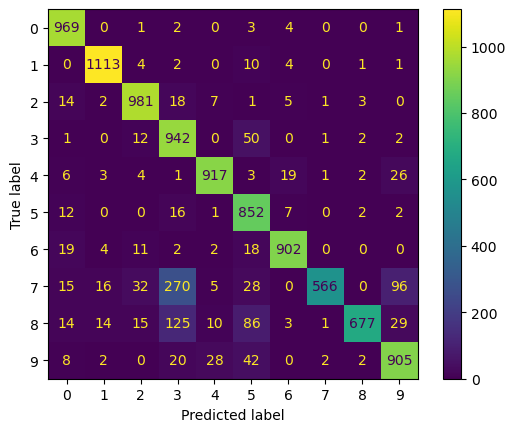

In [89]:
# display confusion matrix between test output and predicted output

cm = confusion_matrix(y_test, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();
#plt.show()

## Lab Logbook requirement: Document the

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

## Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

## 4 Clients

In [90]:
# Split data into 4 clients

In [91]:
Client_1 = (x_train[0:15000], y_train[0:15000])
Client_2 = (x_train[15000:30000], y_train[15000:30000])
Client_3 = (x_train[30000:45000], y_train[30000:45000])
Client_4 = (x_train[45000:], y_train[45000:])

In [92]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)

(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000, 28, 28, 1)
(15000,)
(15000,)
(15000,)
(15000,)


In [93]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.4489 - accuracy: 0.8739
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2220 - accuracy: 0.9375
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1564 - accuracy: 0.9564
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1151 - accuracy: 0.9675
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0902 - accuracy: 0.9755
Epoch 1/5
469/469 [==============================] - 2s 2ms/step - loss: 2.3147 - accuracy: 0.1043
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2967 - accuracy: 0.1193
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2898 - accuracy: 0.1289
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2771 - accuracy: 0.1347
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 2.2594 - accuracy: 0.1530
Epoch 1/5


In [94]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weights3, weights4):
        new_weights.append((w1 + w2 + w3 + w4) / 4)
    return new_weights


In [95]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [96]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 2.2557 - accuracy: 0.2736 - 540ms/epoch - 2ms/step
Test accuracy: 0.2736000120639801


In [97]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 0s 1ms/step
(10000, 10)


In [98]:
print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

Accuracy test set:  0.2736
Precision test set:  0.3014111880169848
Recall test set:  0.2736
F-score test set:  0.2544980233888777
              precision    recall  f1-score   support

           0       0.46      0.16      0.24       980
           1       0.21      0.52      0.30      1135
           2       0.13      0.07      0.09      1032
           3       0.25      0.26      0.25      1010
           4       0.46      0.53      0.49       982
           5       0.31      0.39      0.35       892
           6       0.29      0.35      0.32       958
           7       0.59      0.23      0.33      1028
           8       0.19      0.01      0.02       974
           9       0.15      0.20      0.17      1009

    accuracy                           0.27     10000
   macro avg       0.30      0.27      0.26     10000
weighted avg       0.30      0.27      0.25     10000



In [99]:
test_accuracy.append(0.28790000081062317)
test_precision.append(0.37310911314701634)
test_recall.append(0.2879)
test_f1_score.append(0.2500357846568731)

In [100]:
print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317]
[0.907323157047967, 0.37310911314701634]
[0.8851, 0.2879]
[0.8851514824563385, 0.2500357846568731]


## 6 Clients

In [101]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [102]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5201 - accuracy: 0.8593
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.2455 - accuracy: 0.9295
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1846 - accuracy: 0.9481
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1402 - accuracy: 0.9602
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1151 - accuracy: 0.9659
Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 2.3194 - accuracy: 0.0995
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2952 - accuracy: 0.1160
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2818 - accuracy: 0.1392
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2618 - accuracy: 0.1546
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2394 - accuracy: 0.1687
Epoch 1/5


In [103]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [104]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.9454 - accuracy: 0.7791 - 574ms/epoch - 2ms/step
Test accuracy: 0.7791000008583069
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.7791
Precision test set:  0.8117829644709401
Recall test set:  0.7791
F-score test set:  0.7777405824037334
              precision    recall  f1-score   support

           0       0.95      0.65      0.77       980
           1       0.90      0.96      0.93      1135
           2       0.70      0.83      0.76      1032
           3       0.89      0.66      0.76      1010
           4       0.91      0.72      0.81       982
           5       0.83      0.78      0.80       892
           6       0.59      0.97      0.74       958
           7       0.68      0.93      0.78      1028
           8       0.75      0.74      0.74       974
           9       0.91      0.53      0.67      1009

    accuracy                           0.78     10000
   macro avg       0.81      0.78      0.78    

In [105]:
test_accuracy.append(0.7271999716758728)
test_precision.append(0.7834205071021751)
test_recall.append(0.7272)
test_f1_score.append(0.7308748558259915)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751]
[0.8851, 0.2879, 0.7272]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915]


## 8 Clients

In [106]:
Client_1 = (x_train[0:7500], y_train[0:7500])
Client_2 = (x_train[7500:15000], y_train[7500:15000])
Client_3 = (x_train[15000:22500], y_train[15000:22500])
Client_4 = (x_train[22500:30000], y_train[22500:30000])
Client_5 = (x_train[30000:37500], y_train[30000:37500])
Client_6 = (x_train[37500:45000], y_train[37500:45000])
Client_7 = (x_train[45000:52500], y_train[45000:52500])
Client_8 = (x_train[52500:], y_train[52500:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])

(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500, 28, 28, 1)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
(7500,)
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 0.5784 - accuracy: 0.8447
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 0.2632 - accuracy: 0.9249
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.9444
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1571 - accuracy: 0.9567
Epoch 5/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.9648
Epoch 1/5
235/235 [==============================] - 1s 2ms/step - loss: 2.3263 - accuracy: 0.0956
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 2.2894 - accuracy: 0.1288
Epoch 3/5
235/235 [==============================] - 1s 2ms/step - loss: 2.2695 - accuracy: 0.1523


In [107]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, 
                              weights5, weights6, weights7, weights8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weights1, weights2, weights3, weights4, 
                                              weights5, weights6, weights7, weights8):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 +w8) / 8)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [108]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8888 - accuracy: 0.6356 - 555ms/epoch - 2ms/step
Test accuracy: 0.6355999708175659
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.6356
Precision test set:  0.7859222275035171
Recall test set:  0.6356
F-score test set:  0.6279337909643584
              precision    recall  f1-score   support

           0       0.95      0.49      0.65       980
           1       0.99      0.47      0.64      1135
           2       0.56      0.85      0.67      1032
           3       0.69      0.83      0.75      1010
           4       0.97      0.51      0.66       982
           5       0.36      0.96      0.52       892
           6       0.99      0.43      0.60       958
           7       0.55      0.95      0.70      1028
           8       0.98      0.19      0.32       974
           9       0.78      0.69      0.73      1009

    accuracy                           0.64     10000
   macro avg       0.78      0.64      0.63    

In [109]:
test_accuracy.append(0.6028000116348267)
test_precision.append(0.7986126719530607)
test_recall.append(0.6028)
test_f1_score.append(0.5536289939655649)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607]
[0.8851, 0.2879, 0.7272, 0.6028]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649]


## 10 Clients

In [110]:
Client_1 = (x_train[0:6000], y_train[0:6000])
Client_2 = (x_train[6000:12000], y_train[6000:12000])
Client_3 = (x_train[12000:18000], y_train[12000:18000])
Client_4 = (x_train[18000:24000], y_train[18000:24000])
Client_5 = (x_train[24000:30000], y_train[24000:30000])
Client_6 = (x_train[30000:36000], y_train[30000:36000])
Client_7 = (x_train[36000:42000], y_train[36000:42000])
Client_8 = (x_train[42000:48000], y_train[42000:48000])
Client_9 = (x_train[48000:54000], y_train[48000:54000])
Client_10 = (x_train[54000:], y_train[54000:])

print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)
print(Client_7[0].shape)
print(Client_8[0].shape)
print(Client_9[0].shape)
print(Client_10[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)
print(Client_7[1].shape)
print(Client_8[1].shape)
print(Client_9[1].shape)
print(Client_10[1].shape)

# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])
client7_model = train_client_model(client7_model, Client_7[0], Client_7[1])
client8_model = train_client_model(client8_model, Client_8[0], Client_8[1])
client9_model = train_client_model(client9_model, Client_9[0], Client_9[1])
client10_model = train_client_model(client10_model, Client_10[0], Client_10[1])

(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000, 28, 28, 1)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 0.6480 - accuracy: 0.8240
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.9270
Epoch 3/5
188/188 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9452
Epoch 4/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1573 - accuracy: 0.9600
Epoch 5/5
188/188 [==============================] - 0s 2ms/step - loss: 0.1200 - accuracy: 0.9670
Epoch 1/5
188/188 [==============================] - 1s 2ms/step - loss: 2.3244 - accuracy: 0.1010
Epoch 2/5
188/188 [==============================] - 0s 2ms/step - loss: 2.2845 - accuracy: 0.1353
Epoch 3/5
188/188 [============================

In [111]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5,
                              weights6, weights7, weights8, weights9, weights10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weights1, weights2, weights3, weights4, 
                                                      weights5, weights6, weights7, weights8, 
                                                      weights9, weights10):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6 + w7 + w8 + w9 + w10) / 10)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights(),
                                               client7_model.get_weights(),
                                               client8_model.get_weights(),
                                               client9_model.get_weights(),
                                               client10_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [112]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.8050 - accuracy: 0.6672 - 549ms/epoch - 2ms/step
Test accuracy: 0.6672000288963318
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.6672
Precision test set:  0.8017596744725294
Recall test set:  0.6672
F-score test set:  0.652423245083419
              precision    recall  f1-score   support

           0       0.99      0.44      0.61       980
           1       0.98      0.67      0.80      1135
           2       0.64      0.83      0.72      1032
           3       0.83      0.77      0.80      1010
           4       0.80      0.94      0.86       982
           5       0.31      0.97      0.47       892
           6       0.95      0.79      0.86       958
           7       0.67      0.93      0.78      1028
           8       0.83      0.11      0.19       974
           9       0.96      0.25      0.39      1009

    accuracy                           0.67     10000
   macro avg       0.80      0.67      0.65     

In [113]:
test_accuracy.append(0.6428999900817871)
test_precision.append(0.8044962589008876)
test_recall.append(0.6429)
test_f1_score.append(0.6203729491096158)

print(test_accuracy)
print(test_precision)
print(test_recall)
print(test_f1_score)

[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871]
[0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876]
[0.8851, 0.2879, 0.7272, 0.6028, 0.6429]
[0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]


### Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

In [114]:
import pandas as pd

In [115]:
ErrorMetrics = []
ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1_score)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.8851000070571899, 0.28790000081062317, 0.7271999716758728, 0.6028000116348267, 0.6428999900817871], [0.907323157047967, 0.37310911314701634, 0.7834205071021751, 0.7986126719530607, 0.8044962589008876], [0.8851, 0.2879, 0.7272, 0.6028, 0.6429], [0.8851514824563385, 0.2500357846568731, 0.7308748558259915, 0.5536289939655649, 0.6203729491096158]]


,Accuracy,Precision,Recall,F1_Score
2,0.8851,0.907323,0.8851,0.885151
4,0.2879,0.373109,0.2879,0.250036
6,0.7272,0.783421,0.7272,0.730875
8,0.6028,0.798613,0.6028,0.553629
10,0.6429,0.804496,0.6429,0.620373


<Axes: >

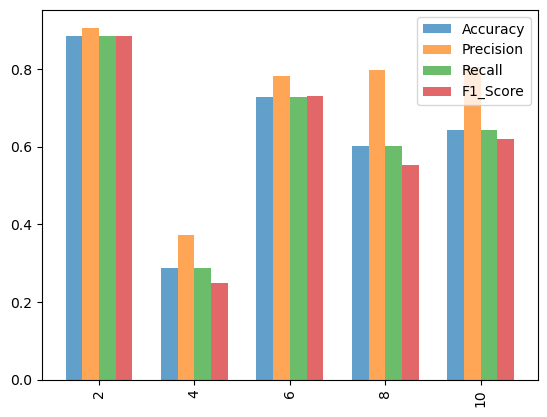

In [116]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)

### 2.For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.

#### Take 6 Clients, one of them is assumed dishonest



In [117]:
# Split data into 6 clients

In [118]:
Client_1 = (x_train[0:10000], y_train[0:10000])
Client_2 = (x_train[10000:20000], y_train[10000:20000])
Client_3 = (x_train[20000:30000], y_train[20000:30000])
Client_4 = (x_train[30000:40000], y_train[30000:40000])
Client_5 = (x_train[40000:50000], y_train[40000:50000])
Client_6 = (x_train[50000:], y_train[50000:])

In [119]:
Client_2[1].size

10000

In [120]:
Client_2[1]

array([3, 8, 7, ..., 1, 4, 2], dtype=uint8)

In [121]:

Client_2[1][:2000] = 4

In [122]:
Client_2[1]

array([4, 4, 4, ..., 1, 4, 2], dtype=uint8)

In [123]:
print(Client_1[0].shape)
print(Client_2[0].shape)
print(Client_3[0].shape)
print(Client_4[0].shape)
print(Client_5[0].shape)
print(Client_6[0].shape)

print(Client_1[1].shape)
print(Client_2[1].shape)
print(Client_3[1].shape)
print(Client_4[1].shape)
print(Client_5[1].shape)
print(Client_6[1].shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)


In [124]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()

client1_model = train_client_model(client1_model, Client_1[0], Client_1[1])
client2_model = train_client_model(client2_model, Client_2[0], Client_1[1])
client3_model = train_client_model(client3_model, Client_3[0], Client_1[1])
client4_model = train_client_model(client4_model, Client_4[0], Client_1[1])
client5_model = train_client_model(client5_model, Client_5[0], Client_5[1])
client6_model = train_client_model(client6_model, Client_6[0], Client_6[1])

Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5180 - accuracy: 0.8609
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.2409 - accuracy: 0.9324
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1792 - accuracy: 0.9490
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1357 - accuracy: 0.9622
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.1125 - accuracy: 0.9685
Epoch 1/5
313/313 [==============================] - 1s 2ms/step - loss: 2.3211 - accuracy: 0.1006
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2929 - accuracy: 0.1265
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2783 - accuracy: 0.1449
Epoch 4/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2582 - accuracy: 0.1559
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 2.2321 - accuracy: 0.1735
Epoch 1/5


In [125]:
# Federated averaging
def federated_average_weights(weights1, weights2, weights3, weights4, weights5, weights6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weights1, weights2, weights3, weights4, weights5, weights6):
        new_weights.append((w1 + w2 + w3 + w4 + w5 + w6) / 6)
    return new_weights


# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), 
                                               client2_model.get_weights(), 
                                               client3_model.get_weights(),
                                               client4_model.get_weights(),
                                               client5_model.get_weights(),
                                               client6_model.get_weights())

# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [126]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

print("Accuracy test set: ", accuracy_score(y_test, predictions))

print("Precision test set: ", precision_score(y_test, predictions, average = 'weighted' )) 
print("Recall test set: ", recall_score(y_test, predictions, average = 'weighted' ))
print("F-score test set: ", f1_score(y_test, predictions, average = 'weighted' ))

print(classification_report(y_test, predictions))

313/313 - 1s - loss: 1.9384 - accuracy: 0.6869 - 551ms/epoch - 2ms/step
Test accuracy: 0.6869000196456909
313/313 [==============================] - 0s 1ms/step
(10000, 10)
Accuracy test set:  0.6869
Precision test set:  0.7590900377745127
Recall test set:  0.6869
F-score test set:  0.6738907535666296
              precision    recall  f1-score   support

           0       0.95      0.53      0.68       980
           1       0.77      0.99      0.87      1135
           2       0.62      0.83      0.71      1032
           3       0.72      0.73      0.73      1010
           4       0.85      0.50      0.63       982
           5       0.46      0.94      0.61       892
           6       0.92      0.47      0.63       958
           7       0.60      0.87      0.71      1028
           8       0.93      0.26      0.40       974
           9       0.76      0.70      0.73      1009

    accuracy                           0.69     10000
   macro avg       0.76      0.68      0.67    

In [127]:
test_accuracy_dishonest  = []
test_precision_dishonest = []
test_recall_dishonest    = []
test_f1_score_dishonest  = []

In [128]:
test_accuracy_dishonest.append(test_accuracy[2])
test_precision_dishonest.append(test_precision[2])
test_recall_dishonest.append(test_recall[2])
test_f1_score_dishonest.append(test_f1_score[2])

test_accuracy_dishonest.append(0.7197999954223633)
test_precision_dishonest.append(0.7649681801937827)
test_recall_dishonest.append(0.7198)
test_f1_score_dishonest.append(0.7079021148713025)

print(test_accuracy_dishonest)
print(test_precision_dishonest)
print(test_recall_dishonest)
print(test_f1_score_dishonest)

[0.7271999716758728, 0.7197999954223633]
[0.7834205071021751, 0.7649681801937827]
[0.7272, 0.7198]
[0.7308748558259915, 0.7079021148713025]


In [129]:
### Plot the model's performance for the 6 clients, one of them (number=2) is dishonest

ErrorMetrics = []
ErrorMetrics.append(test_accuracy_dishonest)
ErrorMetrics.append(test_precision_dishonest)
ErrorMetrics.append(test_recall_dishonest)
ErrorMetrics.append(test_f1_score_dishonest)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['All are honest', '#2 is dishonest']
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy','Precision','Recall','F1_Score']
ErrorMetrics_pd

[[0.7271999716758728, 0.7197999954223633], [0.7834205071021751, 0.7649681801937827], [0.7272, 0.7198], [0.7308748558259915, 0.7079021148713025]]


,Accuracy,Precision,Recall,F1_Score
All are honest,0.7272,0.783421,0.7272,0.730875
#2 is dishonest,0.7198,0.764968,0.7198,0.707902


<Axes: >

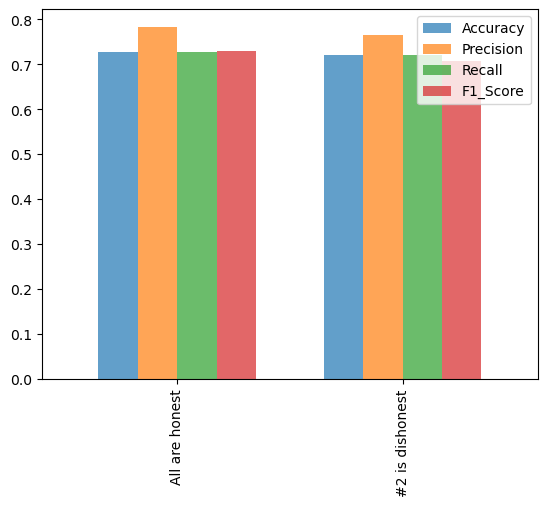

In [130]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)